In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, \
precision_recall_curve, auc
import os 
import sys

In [4]:
%run -i generate_dataset.py

In [5]:
img , lables = generate_dataset(img_size = 5 , 
                                n_images = 300 , 
                                binary = True , 
                                seed = 13 )

In [6]:
#data preparation 
X_tensor  = torch.as_tensor(img / 255).float()
y_tensor =  torch.as_tensor(lables.reshape(-1,1)).float()

X_tensor.shape , y_tensor.shape

(torch.Size([300, 1, 5, 5]), torch.Size([300, 1]))

In [7]:
# data transformation 
from torch.utils.data import Dataset 
class TransformTensorDataset(Dataset):
    def __init__(self , x , y , transform = None ) :
        self.x = x 
        self.y = y 
        self.transform = transform

    def __getitem__(self , index):
        if self.transform : 
            x = self.transform(self.x[index])

        return x , self.y[index]
    
    def __len__(self):
        return len(self.x)
    

In [8]:
#index splitter 
from torch.utils.data import random_split 
def index_splitter(n , splits , seed = 13):
    idx = torch.arange(n)
    split_tensor = torch.as_tensor(splits).float()
    multiplier = n / split_tensor.sum()
    split_tensor = (multiplier * split_tensor ).long()
    diff = n  - split_tensor.sum() 
    split_tensor[0] = split_tensor[0] + diff 
    torch.manual_seed(seed)
    return random_split(idx , split_tensor)

In [9]:
len(X_tensor)

300

In [10]:
from torchvision import transforms

compose = transforms.Compose([transforms.RandomHorizontalFlip(p = 0.5) , 
                              transforms.Normalize(mean = (.5) , std = (.5))])

dataset  = TransformTensorDataset(X_tensor , y_tensor , transform= compose )

d:\software\miniconda\envs\mlenv\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [11]:
train_idx , val_idx =index_splitter(len(X_tensor), [80 , 20])

In [12]:
#USING SETSET DATA SAMPLER 
from torch.utils.data.sampler  import SubsetRandomSampler
train_sampler  = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [13]:
# build data loader 

train_loader = DataLoader(
    dataset= dataset , 
    batch_size = 16 , 
    sampler = train_sampler 
)

val_loader = DataLoader(
    dataset= dataset , 
    batch_size = 16 , 
    sampler = val_sampler
)

In [14]:
#using indices to perfrom splits
X_train_tensor  = X_tensor[train_idx]
y_train_tensor = y_tensor[train_idx] 
X_val_tensor = X_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

X_train_tensor.shape , y_train_tensor.shape 

(torch.Size([240, 1, 5, 5]), torch.Size([240, 1]))

In [15]:
from torchvision import transforms 

train_composer = transforms.Compose([transforms.RandomHorizontalFlip(p = 1) , 
                                     transforms.Normalize(mean = (.5) , std = (.5))])
val_composer = transforms.Compose([transforms.Normalize(mean =(.5)  , std = (.5))])


In [16]:
train_dataset = TransformTensorDataset(X_train_tensor , y_train_tensor , transform = train_composer)

val_dataset = TransformTensorDataset(X_train_tensor , y_train_tensor , transform = train_composer)

#data loader 
train_loader = DataLoader(
    dataset = train_dataset , 
    batch_size = 16 , 
    shuffle= True
) 
val_loader = DataLoader(
    dataset = val_dataset, 
    batch_size= 16
)  

In [17]:
y_train_tensor.shape


torch.Size([240, 1])

In [18]:
classes , counts = y_train_tensor.unique(return_counts= True)
classes , counts

(tensor([0., 1.]), tensor([ 80, 160]))

In [19]:
weights = 1 / counts.float()

In [20]:
sample_weights = weights[y_train_tensor.squeeze().long()]
sample_weights[:10]

tensor([0.0063, 0.0063, 0.0063, 0.0063, 0.0063, 0.0125, 0.0063, 0.0063, 0.0063,
        0.0063])

In [21]:
from torch.utils.data  import WeightedRandomSampler 

generator  = torch.Generator()
sampler = WeightedRandomSampler(
    weights = sample_weights , 
    num_samples=  len(sample_weights) , 
    generator = generator , 
    replacement= True 
)

## note that if we are using sampler we cannout use the Shuffle Argument 

In [22]:
# recreate the data loaders using the weighted sampler with the training set 
train_loader = DataLoader(
    dataset = train_dataset , 
    batch_size = 16 , 
    sampler = sampler 
)

val_loader =   DataLoader(
    dataset = val_dataset , batch_size = 16 ) 


In [23]:
%%writefile make_balanced_sampler.py
def make_balanced_sampler(y):
    classes , counts = y.unique(return_counts = True )
    weights = 1.0 / counts.float()
    sample_weights = weights[y.squeeze().long()]
    #build sampler with compute weights 
    generator  = torch.Generator()
    sampler = WeightedRandomSampler(
        weights = sample_weights , 
        num_samples= len(sample_weights), 
        generator= generator , 
        replacement= True
    )
    return sampler

Overwriting make_balanced_sampler.py


In [24]:
%run -i make_balanced_sampler.py

In [25]:
sampler = make_balanced_sampler(y_train_tensor)
sampler

Let’s have it sample a full
run (240 data points in 15 mini-batches of 16 points each), and sum up the labels so
we know how many points are in the positive class:

In [26]:
train_loader

In [27]:
([t[1].sum() for t in iter(train_loader)])
# here are 15 batches below  

[tensor(10.),
 tensor(6.),
 tensor(11.),
 tensor(7.),
 tensor(8.),
 tensor(9.),
 tensor(9.),
 tensor(6.),
 tensor(6.),
 tensor(10.),
 tensor(8.),
 tensor(14.),
 tensor(7.),
 tensor(9.),
 tensor(9.)]

In [28]:
# 240 data points 15 mini batches and 16 points each 
torch.tensor([t[1].sum()  for t in iter(train_loader)]).sum()

tensor(130.)

Previous we have 160 images of positive now we ahve 125 only , due to weight sampler , and 


# notice we have use two seeds ' but why ? 

In [27]:
# def set_seed(self , seed = 42):
#     torch.backends.cudnn.deterministic = True 
#     torch.backends.cudnn.benchmark = False 
#     torch.manual_seed(seed)
#     np.random.seed(seed)
#     random.seed(seed)

#     try : 
#         self.train_loader.sampler.generator.manual_seed(seed)
#     except AttributeError:
#         pass 

# setattr(StepByStep , 'set_seed' , set_seed)

## Data preParation


In [28]:
X_tensor = torch.as_tensor(img/255).float()
y_tensor  = torch.as_tensor(lables.reshape(-1 , 1)).float()

## use index_splitter to split datasets 
train_idx , val_idx = index_splitter(len(X_tensor ), [80 , 20])
#use indices to perform split
X_train_tensor = X_tensor[train_idx]
y_tensor_tensor = y_tensor[train_idx]
X_test_tesnor = X_tensor[val_idx]
y_test_tensor = y_tensor[val_idx]

####### use composer 
train_composer = transforms.Compose([transforms.RandomHorizontalFlip(p = 1) , 
                                     transforms.Normalize(mean =(.5) ,std = (.5))])
val_composer = transforms.Compose([transforms.Normalize(mean = (.5) , std = (.5))])

######### make dataset now 
train_dataset = TransformTensorDataset(X_train_tensor , y_train_tensor , transform= train_composer )
val_dataset = TransformTensorDataset(y_train_tensor , y_test_tensor , transform = train_composer )

## up to here data is transformed 

## now fixing imbalance classes by giving more weights to lower number of classes  and vice versa
sampler = make_balanced_sampler(y_train_tensor)

train_loader = DataLoader(dataset = train_dataset , batch_size= 16 , sampler = sampler )
val_loader = DataLoader(dataset = val_dataset , batch_size = 16)

In [29]:
dummy_batch_data , dummy_batch_label = next(iter(train_loader))


In [30]:
dummy_batch_data.shape
# 16 images  ,1 channel each of 5 *  5 height and weight 

torch.Size([16, 1, 5, 5])

In [31]:
#lets flattern 
flattern = torch.nn.Flatten()
dummy_batch_data_flatten = flattern(dummy_batch_data)
print(dummy_batch_data_flatten.shape)
print(dummy_batch_data_flatten[0])

torch.Size([16, 25])
tensor([-1., -1., -1.,  1., -1., -1., -1., -1.,  1., -1., -1., -1., -1.,  1.,
        -1., -1., -1., -1.,  1., -1., -1., -1., -1.,  1., -1.])


In [32]:
import matplotlib.pyplot as plt 

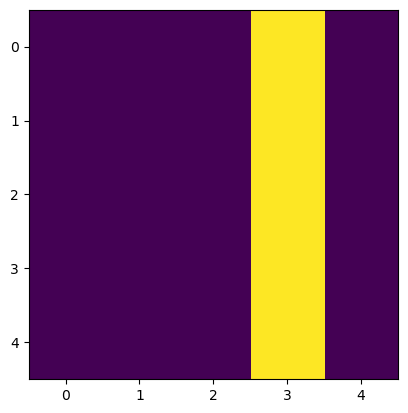

In [33]:
plt.imshow(dummy_batch_data[0].squeeze())

looses its origina content  👇🏽

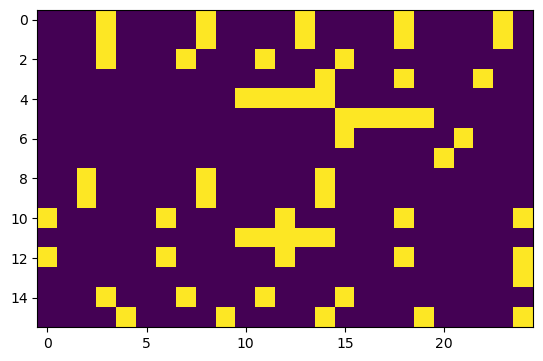

In [34]:
plt.imshow(dummy_batch_data_flatten)

## Model COnfiguration 

In [35]:
lr = 0.1 
torch.manual_seed(42)
#now we can create a model 
model_logistic = torch.nn.Sequential()
model_logistic.add_module('flattern' , nn.Flatten())
model_logistic.add_module('output', nn.Linear(25 , 1 , bias = False))
model_logistic.add_module('sigmoid' , nn.Sigmoid())
## Define an SGD Optimizer to update 
optimizer_logistic = torch.optim.SGD(
    model_logistic.parameters() , lr = lr 
)

#define binary cross entropy
binary_loss_fn = nn.BCELoss()

In [36]:
#train our model with 100 epochs 
n_epochs = 100 

In [37]:
pwd

'd:\\ujjwal\\Deep-learning\\computer_vision'

In [38]:
cd ..

d:\ujjwal\Deep-learning


C:\Users\Ujjwal\AppData\Roaming\Python\Python311\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [39]:
next(iter(train_loader))

[tensor([[[[ 1., -1., -1., -1., -1.],
           [-1., -1., -1., -1., -1.],
           [-1., -1., -1., -1., -1.],
           [-1., -1., -1., -1., -1.],
           [-1., -1., -1., -1., -1.]]],
 
 
         [[[-1., -1., -1., -1., -1.],
           [-1., -1., -1., -1., -1.],
           [-1., -1., -1., -1., -1.],
           [-1., -1., -1., -1.,  1.],
           [-1., -1., -1.,  1., -1.]]],
 
 
         [[[-1., -1., -1., -1., -1.],
           [ 1., -1., -1., -1., -1.],
           [-1.,  1., -1., -1., -1.],
           [-1., -1.,  1., -1., -1.],
           [-1., -1., -1.,  1., -1.]]],
 
 
         [[[-1., -1., -1.,  1., -1.],
           [-1., -1.,  1., -1., -1.],
           [-1.,  1., -1., -1., -1.],
           [ 1., -1., -1., -1., -1.],
           [-1., -1., -1., -1., -1.]]],
 
 
         [[[-1., -1., -1., -1., -1.],
           [-1., -1., -1., -1., -1.],
           [-1., -1., -1., -1., -1.],
           [ 1.,  1.,  1.,  1.,  1.],
           [-1., -1., -1., -1., -1.]]],
 
 
         [[[-1., -1.

In [45]:
pwd

'd:\\ujjwal\\Deep-learning'

In [46]:
from stepbystep_v0 import StepByStep

In [47]:
def divide(dividend, divisor):

    if dividend == 0:
        return 0

    if divisor == 0:
        return None

    sign = 1
    if dividend < 0 and divisor > 0:
        sign = -1
    elif dividend > 0 and divisor < 0:
                                                sign = -1

    dividend = abs(dividend)
    divisor = abs(divisor)

    res = 0
    while dividend >= divisor:
        dividend -= divisor
        res += 1

    return sign * res

In [48]:
divide(10 ,-3)

-3

In [49]:
n_epcohs = 100
sbs_logistic= StepByStep(model = model_logistic  , loss_fn = binary_loss_fn , optimizer= optimizer_logistic)
sbs_logistic.set_loaders(train_loader , val_loader)
sbs_logistic.train(n_epochs)

TypeError: Tensor is not a torch image.

In [1]:
board = [["5","3",".",".","7",".",".",".","."],["6",".",".","1","9","5",".",".","."],[".","9","8",".",".",".",".","6","."],["8",".",".",".","6",".",".",".","3"],["4",".",".","8",".","3",".",".","1"],["7",".",".",".","2",".",".",".","6"],[".","6",".",".",".",".","2","8","."],[".",".",".","4","1","9",".",".","5"],[".",".",".",".","8",".",".","7","9"]]

In [2]:
board

[['5', '3', '.', '.', '7', '.', '.', '.', '.'],
 ['6', '.', '.', '1', '9', '5', '.', '.', '.'],
 ['.', '9', '8', '.', '.', '.', '.', '6', '.'],
 ['8', '.', '.', '.', '6', '.', '.', '.', '3'],
 ['4', '.', '.', '8', '.', '3', '.', '.', '1'],
 ['7', '.', '.', '.', '2', '.', '.', '.', '6'],
 ['.', '6', '.', '.', '.', '.', '2', '8', '.'],
 ['.', '.', '.', '4', '1', '9', '.', '.', '5'],
 ['.', '.', '.', '.', '8', '.', '.', '7', '9']]

In [4]:
import collections

In [8]:
N  = 9 

In [13]:
[c for c in range(N) ]

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [11]:
row

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [29]:
for r in range(N):
    row = [c for c in board[r] if c!='.']
    if len(row)!= len(set(row)) : return False 
    

In [53]:
a = True 

In [55]:
if not a:
    print("Fasd")

In [56]:
if a :
    print("fad")

fad


In [46]:
for c in range(N):
    col = [board[r][c] for r in range(N) if board[r][c] !='.']

In [47]:
col

['3', '1', '6', '5', '9']

In [51]:
l = set()
l.add(2)

In [52]:
if 2 in l:
    print("s")

s


In [50]:
l = set()
for r in range(0 , 9, 3):
    for c in range(0 , 9 , 3):
        if board[r][c] in l :
            


0
3
6
0
3
6
0
3
6


In [45]:
board[0][0:]

['5', '3', '.', '.', '7', '.', '.', '.', '.']

In [28]:
r

8

In [58]:
for  r in range(N):
    row = [c for c in board[r] if c!='.']
    if len(row) != len(set(row)) : "false"

In [59]:
 for c in range(N):
            col = [board[r][c] for r in range(N) if board[r][c] != 0]
            if len(col) != len(set(col)): "false"
        

In [65]:
def helper(R , C):
            l = set() 
            for r in range(R , R + 3):
                for c in range(C , C + 3):
                    if board[r][c] == '.':continue 
                    if board[r][c] not in l:
                        l.add(board[r][c])
                    else :
                        return False 
            return True 

for r in range(0 , N , 3):
        for c in range(0 , N , 3):
            if not helper(r , c):"False"
            print("fa")

fa
fa
fa
fa
fa
fa
fa
fa
fa
